# 10-MobileNet

[1.Depth-Wise Convolution](#1)
  - [1-1.Standard Convolution](#1-1)
  - [1-2.Depthwise Convoluton](#1-2)

[2.Point-Wise Convolution](#2)

[3.Depth-Wise Separable Convolution](#3)

[4.MobileNet](#4)

[5.Training](#5)
 - [5-1.Hyper Parameters](#5-1)
 - [5-2.5-2.Load Dataset](#5-2)
 - [5-3.Train & Valid functions](#5-3)
 - [5-4.Training iteration](#5-4)

[6.Conv MobileNet](#6)

In [27]:
import os
import cv2
import torch
import albumentations as A
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torchsummary import summary
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

<a id="1"></a>
## 1.Depth Wise Convoltion

일반적인 Convolution은 입력된 이미지의 채널과 같은 크기의 채널로 구성된 필터를 적용한다.

반면, Depthwise convolution은 입력 이미지의 채널마다 하나의 필터가 적용된다.

따라서 더 작은 파라미터 수를 가지며, 입력의 height, width만 조절할 뿐, channel의 값은 변하지 않는다.

<a id="1-1"></a>
### 1-1.Standard Convolution

In [28]:
dummy_input = torch.randn(1, 3, 224, 224)

standard_conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
standard_output = standard_conv(dummy_input)
print(standard_output.shape)

torch.Size([1, 64, 224, 224])


In [29]:
num_params = sum(p.numel() for p in standard_conv.parameters()) ## 각 파라미터 텐서 p에 있는 원소의 총 개수

print(f"Output shape: {standard_output.shape}")
print(f"Number of parameters: {num_params}")

Output shape: torch.Size([1, 64, 224, 224])
Number of parameters: 1792


In [30]:
computation_complexity = (
    2 * 
    standard_output.shape[1] * ## num filters
    standard_output.shape[2] * ## height
    standard_output.shape[3] * ## width
    standard_conv.kernel_size[0] * ## filter size
    standard_conv.kernel_size[1] * ## filter size
    standard_conv.in_channels ## input channels
)

print(f"computation_complexity: {computation_complexity}")

computation_complexity: 173408256


<a id="1-2"></a>
### 1-2.Depthwise Convolution

In [31]:
depth_wise_conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1, groups=3)
depth_wise_output = depth_wise_conv(dummy_input)
print(depth_wise_output.shape)

torch.Size([1, 3, 224, 224])


In [32]:
num_params = sum(p.numel() for p in depth_wise_conv.parameters()) ## 각 파라미터 텐서 p에 있는 원소의 총 개수

print(f"Output shape: {depth_wise_output.shape}")
print(f"Number of parameters: {num_params}")

Output shape: torch.Size([1, 3, 224, 224])
Number of parameters: 30


In [33]:
output_height, output_width = depth_wise_output.shape[2], depth_wise_output.shape[3]
computation_complexity = 3 * 3 * 3 * output_height * output_width
print(f"Computation complexity: {computation_complexity}")

Computation complexity: 1354752


<a id="2"></a>
## 2.Pointwise Convolution

이전 내용에서도 몇 번 사용했던, $1\times 1$ convolution으로, 입력되는 채널의 값이 depthwise convolution의 out_channels와 같기 때문에, 해상도의 크기는 조정되지 않는다.

단, pointwise convolution의 out_channels는 설정하는 값에 따라 변화된다.(채널의 크기를 줄이거나 증가시키거나 둘 중 하나.)

In [34]:
depth_wise_conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1, groups=3)
depth_wise_output = depth_wise_conv(dummy_input)
print(depth_wise_output.shape)

point_wise_conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1)
point_wise_output = point_wise_conv(depth_wise_output)
print(point_wise_output.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 224, 224])


In [35]:
num_params = sum(p.numel() for p in point_wise_conv.parameters()) ## 각 파라미터 텐서 p에 있는 원소의 총 개수

print(f"Output shape: {point_wise_output.shape}")
print(f"Number of parameters: {num_params}")

Output shape: torch.Size([1, 1, 224, 224])
Number of parameters: 4


<a id="3"></a>
## 3.Depthwise Separable Convolution

In [36]:
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, width_multiplier=1.0):
        super().__init__()
        in_channels = int(in_channels * width_multiplier)
        out_channels = int(out_channels * width_multiplier)

        self.depth_wise_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        self.point_wise_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depth_wise_conv(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.point_wise_conv(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [37]:
dummy_input = torch.randn(1, 3, 224, 224)
depth_wise_sep_conv = DepthwiseSeparableConv2d(in_channels=3, out_channels=64)
output = depth_wise_sep_conv(dummy_input)
print(output.shape)

torch.Size([1, 64, 224, 224])


<a id="4"></a>
## 4.MobileNet

In [38]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=1000, width_multiplier=1.0, init_weights=False):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(in_channels=32, out_channels=64, stride=1, width_multiplier=width_multiplier),
            DepthwiseSeparableConv2d(in_channels=64, out_channels=128, stride=2, width_multiplier=width_multiplier),
            DepthwiseSeparableConv2d(in_channels=128, out_channels=128, stride=1, width_multiplier=width_multiplier),
            DepthwiseSeparableConv2d(in_channels=128, out_channels=256, stride=2, width_multiplier=width_multiplier),
            DepthwiseSeparableConv2d(in_channels=256, out_channels=256, stride=1, width_multiplier=width_multiplier),
            DepthwiseSeparableConv2d(in_channels=256, out_channels=512, stride=2, width_multiplier=width_multiplier),
            DepthwiseSeparableConv2d(in_channels=512, out_channels=512, stride=1, width_multiplier=width_multiplier),
            DepthwiseSeparableConv2d(in_channels=512, out_channels=512, stride=1, width_multiplier=width_multiplier),
            DepthwiseSeparableConv2d(in_channels=512, out_channels=512, stride=1, width_multiplier=width_multiplier),
            DepthwiseSeparableConv2d(in_channels=512, out_channels=512, stride=1, width_multiplier=width_multiplier),
            DepthwiseSeparableConv2d(in_channels=512, out_channels=512, stride=1, width_multiplier=width_multiplier),
            DepthwiseSeparableConv2d(in_channels=512, out_channels=1024, stride=2, width_multiplier=width_multiplier),
            DepthwiseSeparableConv2d(in_channels=1024, out_channels=1024, stride=1, width_multiplier=width_multiplier),
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(1024, num_classes)

        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.avg_pool(x)
        x = x.view(-1, 1024)
        x = self.classifier(x)

        return x

<a id="5"></a>
## 5.Training

<a id="5-1"></a>
### 5-1.Hyper Parameters

In [39]:
data_dir = "/home/pervinco/Datasets/mammals-classification/data"
save_dir = "./runs/mammal-classification/resnet"

epochs = 300
batch_size = 64
learning_rate = 0.1
lr_patience = 10
lr_decay_factor = 0.1
weight_decay = 0.0001
momentum = 0.9

num_workers = os.cpu_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<a id="5-2"></a>
### 5-2.Load Dataset

In [40]:
classes = sorted(os.listdir(data_dir))
print(classes)

images, labels = [], []
for str_label in classes:
    img_files = os.listdir(f"{data_dir}/{str_label}")
    for file in img_files:
        if file.endswith(".jpg"):
            images.append(f"{data_dir}/{str_label}/{file}")
            labels.append(str_label)

print(f"Num of Classes : {len(classes)}")
print(f"Num of files & labels : {len(images)}, {len(labels)}")
print(images[0])

train_x, valid_x, train_y, valid_y = train_test_split(images, labels, test_size=0.1, shuffle=True, random_state=42)

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

['african_elephant', 'alpaca', 'american_bison', 'anteater', 'arctic_fox', 'armadillo', 'baboon', 'badger', 'blue_whale', 'brown_bear', 'camel', 'dolphin', 'giraffe', 'groundhog', 'highland_cattle', 'horse', 'jackal', 'kangaroo', 'koala', 'manatee', 'mongoose', 'mountain_goat', 'opossum', 'orangutan', 'otter', 'polar_bear', 'porcupine', 'red_panda', 'rhinoceros', 'sea_lion', 'seal', 'snow_leopard', 'squirrel', 'sugar_glider', 'tapir', 'vampire_bat', 'vicuna', 'walrus', 'warthog', 'water_buffalo', 'weasel', 'wildebeest', 'wombat', 'yak', 'zebra']
Num of Classes : 45
Num of files & labels : 13751, 13751
/home/pervinco/Datasets/mammals-classification/data/african_elephant/african_elephant-0125.jpg
12375 12375
1376 1376


In [41]:
class MammalDataset(Dataset):
    def __init__(self, images, labels, classes, mean=None, std=None, augmentation=False):
        self.classes = classes
        self.images = images
        self.labels = labels

        if mean is None:
            mean = (0.485, 0.456, 0.406)

        if std is None:
            std = (0.229, 0.224, 0.225)

        if augmentation:
            self.augmentation = A.Compose([
                A.OneOf([
                    A.Resize(224, 224, p=0.5),
                    A.SmallestMaxSize(max_size=[256, 512], p=0.5)
                ], p=1),
                A.RandomCrop(width=224, height=224),

                A.HorizontalFlip(p=0.4),
                A.RGBShift(p=0.3),

                A.ShiftScaleRotate(p=1.0, shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), 
                                   scale_limit=(-0.099, 0.100), 
                                   rotate_limit=(-180, 180), 
                                   interpolation=0, 
                                   border_mode=0, 
                                   value=(0, 0, 0)),
                A.RandomBrightnessContrast(p=1.0, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
                A.AdvancedBlur(p=0.35, blur_limit=(3, 7), 
                               sigmaX_limit=(0.2, 1.0), 
                               sigmaY_limit=(0.2, 1.0), 
                               rotate_limit=(-90, 90), 
                               beta_limit=(0.5, 8.0), 
                               noise_limit=(0.9, 1.1)),

                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])
        else:
            self.augmentation = A.Compose([
                A.Resize(224, 224, p=1),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.classes.index(label)

        image = self.augmentation(image=image)["image"]

        return image, label

In [42]:
train_dataset = MammalDataset(train_x, train_y, classes, augmentation=True)
valid_dataset = MammalDataset(valid_x, valid_y, classes, augmentation=False)

In [43]:
train_dataloder = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)

<a id="5-3"></a>
### 5-3.Train & Valid functions

In [44]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()

    train_cost, train_acc = 0.0, 0.0
    for x, y in tqdm(dataloader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        cost = criterion(y_pred, y)
        cost.backward()
        optimizer.step()

        train_cost += cost.item() * x.size(0)

        _, pred_labels = torch.max(y_pred, 1)
        train_acc += (pred_labels == y).sum().item()

    train_cost /= len(dataloader.dataset)
    train_acc /= len(dataloader.dataset)

    return train_cost, train_acc


def valid(model, dataloader, criterion, device):
    model.eval()

    valid_cost, valid_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Valid", leave=False):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            cost = criterion(y_pred, y)

            valid_cost += cost.item() * x.size(0)

            _, pred_labels = torch.max(y_pred, 1)
            valid_acc += (pred_labels == y).sum().item()

        valid_cost /= len(dataloader.dataset)
        valid_acc /= len(dataloader.dataset)

    return valid_cost, valid_acc

<a id="5-4"></a>
### 5-4.Training Iteration

In [45]:
model = MobileNet(num_classes=len(classes), width_multiplier=1.0, init_weights=True)
summary(model, input_size=(3, 224, 224), device="cpu")
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]           2,048
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
DepthwiseSeparableConv2d-10         [-1, 64, 112, 112]               0
           Conv2d-11           [-1, 64, 56, 56]             576
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_patience, verbose=True)

train_costs, train_accs = [], []
valid_costs, valid_accs = [], []
early_stop_counter = 0
early_stop_patience = 10
best_valid_cost = float('inf')
for epoch in range(epochs):
    train_cost, train_acc = train(model, train_dataloder, criterion, optimizer, device)
    valid_cost, valid_acc = valid(model, valid_dataloader, criterion, device)

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch : {epoch} | {epochs}")
        print(f"\tTrain Loss : {train_cost:.4f}, Train Acc : {train_acc:.4f}")
        print(f"\tValid Loss : {valid_cost:.4f}, Valid Acc : {valid_acc:.4f}")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    ## Early Stopping
    if valid_cost < best_valid_cost:
        best_valid_cost = valid_cost
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after epoch {epoch} due to no improvement in validation loss")
        break  # Break out of the loop to stop training

    scheduler.step(valid_cost)

Epoch : 0 | 300
	Train Loss : 3.7284, Train Acc : 0.0622
	Valid Loss : 3.4102, Valid Acc : 0.1017


Epoch : 10 | 300
	Train Loss : 2.6547, Train Acc : 0.2861
	Valid Loss : 2.8643, Valid Acc : 0.2696


Epoch : 20 | 300
	Train Loss : 2.0202, Train Acc : 0.4441
	Valid Loss : 2.2692, Valid Acc : 0.3932


Epoch : 30 | 300
	Train Loss : 1.6374, Train Acc : 0.5438
	Valid Loss : 1.6229, Valid Acc : 0.5392


Epoch : 40 | 300
	Train Loss : 1.3823, Train Acc : 0.6057
	Valid Loss : 1.8763, Valid Acc : 0.5167


Epoch : 50 | 300
	Train Loss : 1.2365, Train Acc : 0.6480
	Valid Loss : 1.2890, Valid Acc : 0.6432


Epoch : 60 | 300
	Train Loss : 1.0986, Train Acc : 0.6824
	Valid Loss : 1.5645, Valid Acc : 0.5996
Early stopping triggered after epoch 60 due to no improvement in validation loss


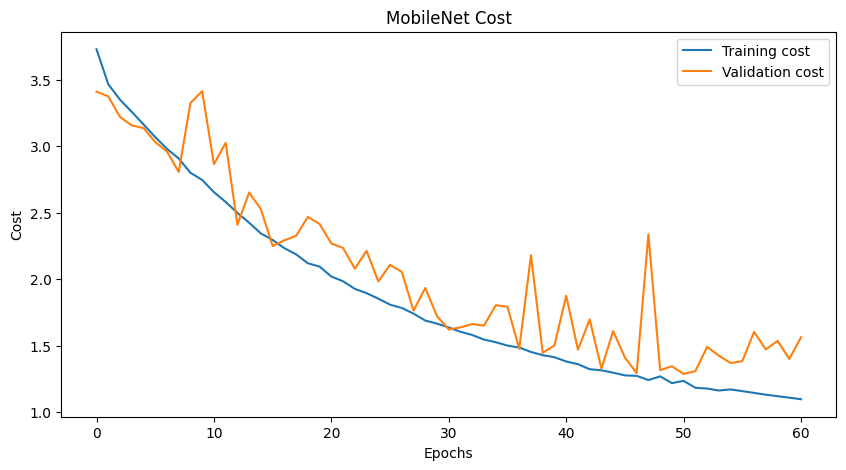

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(train_costs, label='Training cost')
plt.plot(valid_costs, label='Validation cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.title('MobileNet Cost')
plt.show()

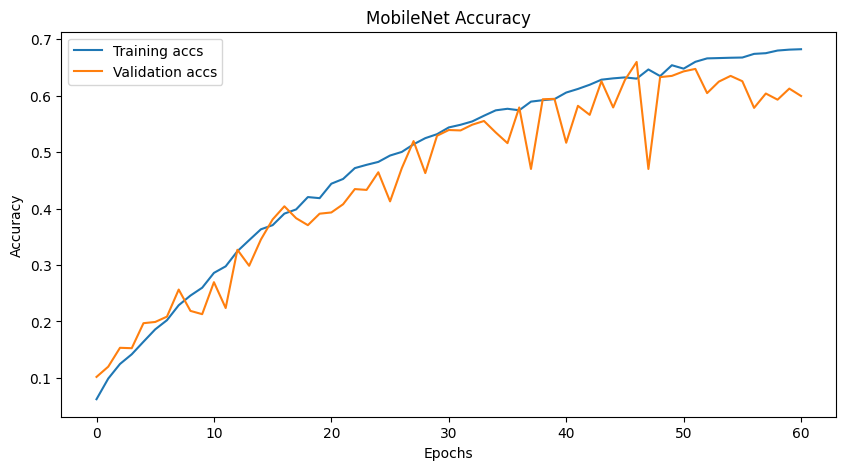

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training accs')
plt.plot(valid_accs, label='Validation accs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MobileNet Accuracy')
plt.show()

<a id="6"></a>
## 6.Conv MobileNet

In [49]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ConvBNReLU, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)

        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [50]:
class ConvMobileNet(nn.Module):
    def __init__(self, num_classes=1000, width_multiplier=1.0, init_weights=False):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            ConvBNReLU(in_channels=32, out_channels=64, stride=1),
            ConvBNReLU(in_channels=64, out_channels=128, stride=2),
            ConvBNReLU(in_channels=128, out_channels=128, stride=1),
            ConvBNReLU(in_channels=128, out_channels=256, stride=2),
            ConvBNReLU(in_channels=256, out_channels=256, stride=1),
            ConvBNReLU(in_channels=256, out_channels=512, stride=2),
            ConvBNReLU(in_channels=512, out_channels=512, stride=1),
            ConvBNReLU(in_channels=512, out_channels=512, stride=1),
            ConvBNReLU(in_channels=512, out_channels=512, stride=1),
            ConvBNReLU(in_channels=512, out_channels=512, stride=1),
            ConvBNReLU(in_channels=512, out_channels=512, stride=1),
            ConvBNReLU(in_channels=512, out_channels=1024, stride=2),
            ConvBNReLU(in_channels=1024, out_channels=1024, stride=1),
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(1024, num_classes)

        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.avg_pool(x)
        x = x.view(-1, 1024)
        x = self.classifier(x)

        return x

In [51]:
model = ConvMobileNet(num_classes=len(classes), init_weights=True)
summary(model, input_size=(3, 224, 224), device="cpu")
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,216
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]           2,048
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
       ConvBNReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 128,

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_patience, verbose=True)

train_costs, train_accs = [], []
valid_costs, valid_accs = [], []
early_stop_counter = 0
early_stop_patience = 10
best_valid_cost = float('inf')
for epoch in range(epochs):
    train_cost, train_acc = train(model, train_dataloder, criterion, optimizer, device)
    valid_cost, valid_acc = valid(model, valid_dataloader, criterion, device)

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch : {epoch} | {epochs}")
        print(f"\tTrain Loss : {train_cost:.4f}, Train Acc : {train_acc:.4f}")
        print(f"\tValid Loss : {valid_cost:.4f}, Valid Acc : {valid_acc:.4f}")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    ## Early Stopping
    if valid_cost < best_valid_cost:
        best_valid_cost = valid_cost
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after epoch {epoch} due to no improvement in validation loss")
        break  # Break out of the loop to stop training

    scheduler.step(valid_cost)

Epoch : 0 | 300
	Train Loss : 3.7511, Train Acc : 0.0406
	Valid Loss : 3.6167, Valid Acc : 0.0451


Epoch : 10 | 300
	Train Loss : 3.3175, Train Acc : 0.1275
	Valid Loss : 3.2495, Valid Acc : 0.1410


Epoch : 20 | 300
	Train Loss : 3.1269, Train Acc : 0.1731
	Valid Loss : 3.1370, Valid Acc : 0.1722


Epoch : 30 | 300
	Train Loss : 2.8374, Train Acc : 0.2430
	Valid Loss : 3.2500, Valid Acc : 0.1788


Epoch : 40 | 300
	Train Loss : 2.5596, Train Acc : 0.3080
	Valid Loss : 2.7781, Valid Acc : 0.2972


Early stopping triggered after epoch 48 due to no improvement in validation loss


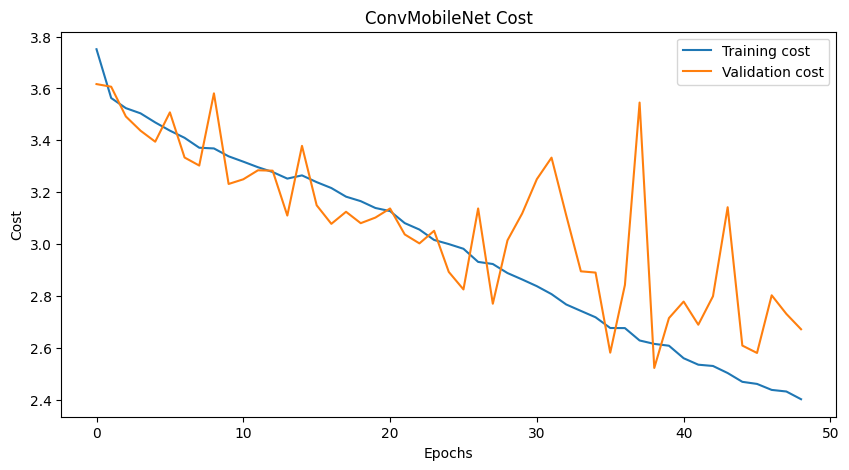

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(train_costs, label='Training cost')
plt.plot(valid_costs, label='Validation cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.title('ConvMobileNet Cost')
plt.show()

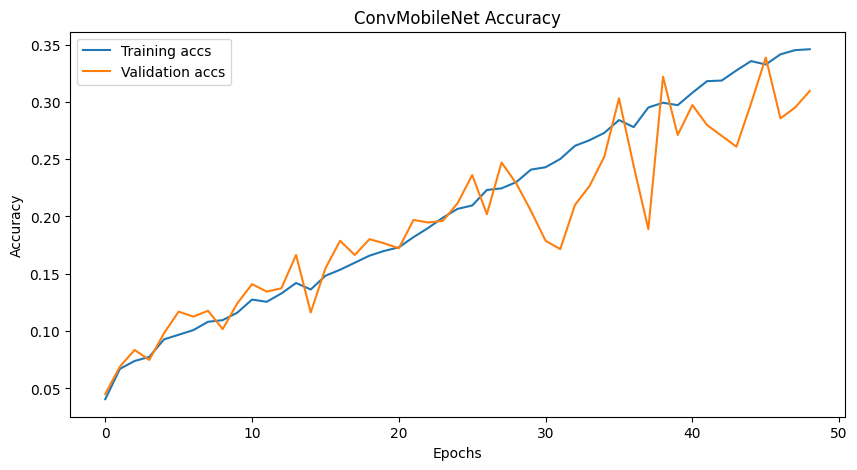

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training accs')
plt.plot(valid_accs, label='Validation accs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ConvMobileNet Accuracy')
plt.show()